# Лабораторная работа №8 "Рекуррентные нейронные сети для анализа временных рядов"

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from google.colab import files

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
files.upload()

### Задание 1.
Загрузите данные. Изобразите ряд в виде графика. Вычислите основные характеристики временного ряда (сезонность, тренд, автокорреляцию).

In [317]:
df = pd.read_csv('Sunspots.csv', index_col='Date', parse_dates=True)
df.rename(columns={'Monthly Mean Total Sunspot Number': 'spot_number'}, inplace=True)
df.drop(columns=['Unnamed: 0'], inplace=True)
df

spot_number
Date                   
1749-01-31         96.7
1749-02-28        104.3
1749-03-31        116.7
1749-04-30         92.8
1749-05-31        141.7
...                 ...
2019-08-31          0.5
2019-09-30          1.1
2019-10-31          0.4
2019-11-30          0.5
2019-12-31          1.6

[3252 rows x 1 columns]

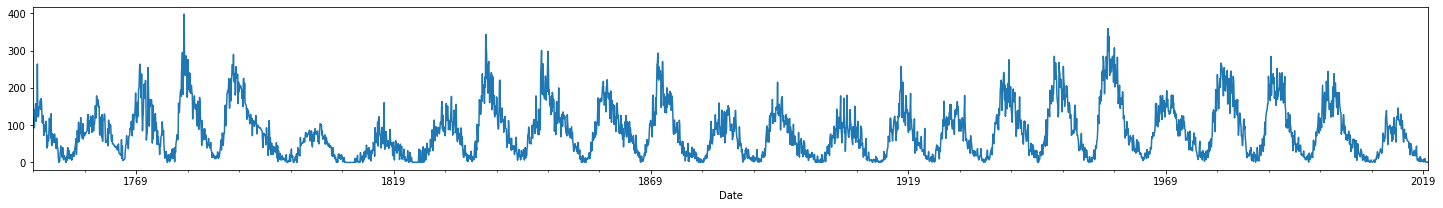

In [4]:
df['spot_number'].plot(figsize=(25, 3))
plt.show()

Разложим наш ряд на три компоненты: тренд, сезонность и остатки (ошибки). Для этого воспользуемся методом декомпозиции STL (A Seasonal-Trend Decomposition Procedure Based on Loess). Мы можем использовать этот метод, потому что мы пердполагаем, что наша модель аддитивная (т.е. ряд является суммой трендовой состовляющей, сезонной и ошибок).

In [ ]:
stl_decomposition = seasonal_decompose(df['spot_number'])

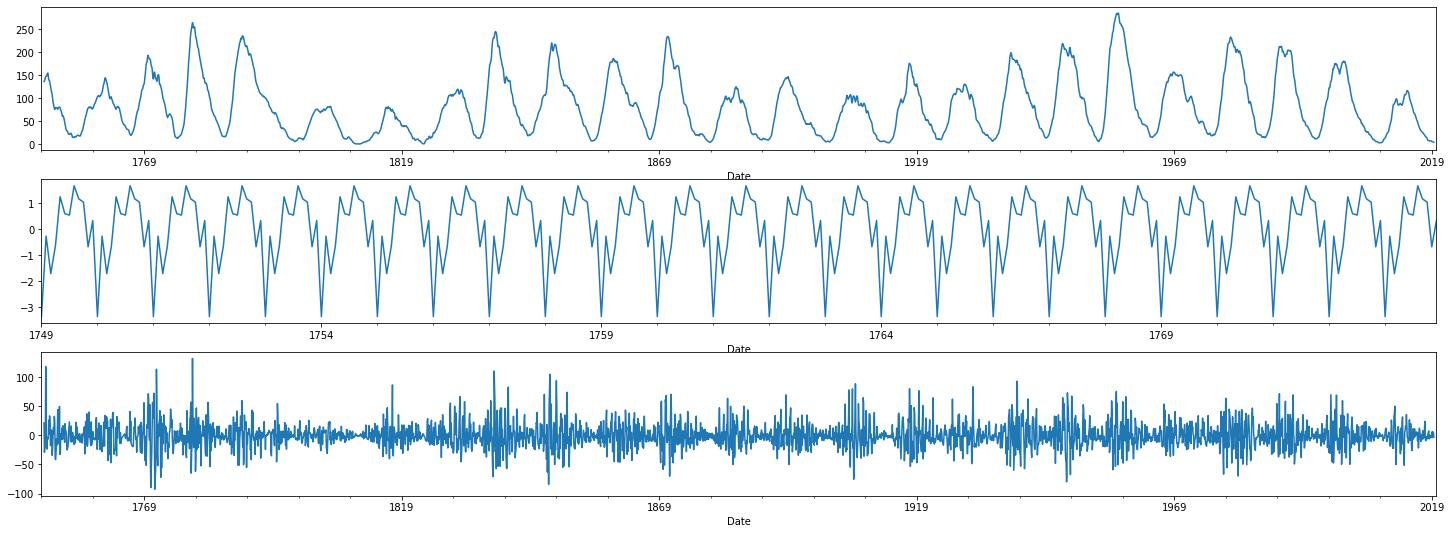

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(25, 9))

stl_decomposition.trend.plot(ax=ax1)
stl_decomposition.seasonal[:300].plot(ax=ax2)
stl_decomposition.resid.plot(ax=ax3)
plt.show()

Исходя из графиков можем сделать вывод, что во временном ряде нет ярковыраженного тренда. Видно что он не растёт и не падает в общем случае. Можно заметить сезонность временного ряда. Это нам говорит о том, что ряд не является стационарным. Про остатки можно сказать, что имеются явные выбросы.

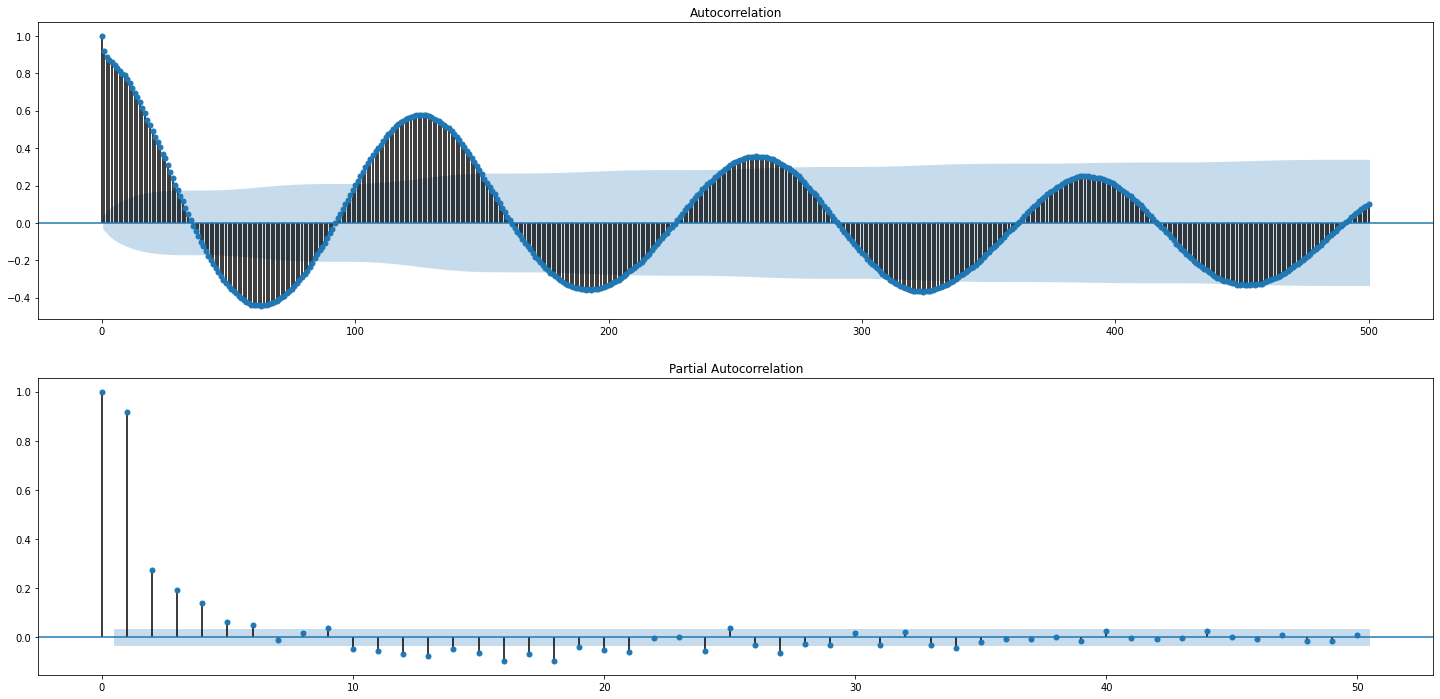

In [381]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 12))
plot_acf(df['spot_number'], lags=500, ax=ax1)
plot_pacf(df['spot_number'], lags=50, ax=ax2)
plt.show()

Как видим, кореллограмма получилась достаточно сглаженная. Поэтому необходимо продифферинцировать временной ряд. Сначала примнеим сезонное дифферинцирование, затем обычное.

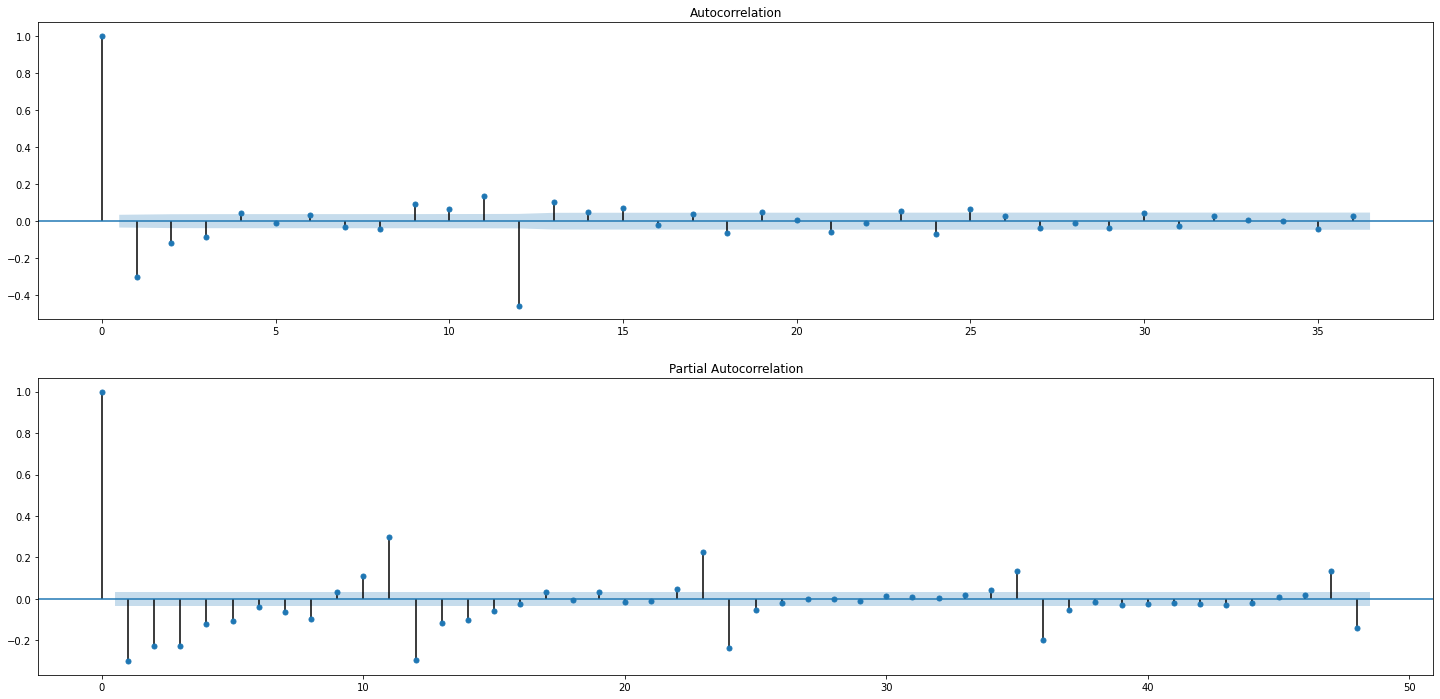

In [384]:
from pmdarima.utils import diff


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 12))
diff_data = diff(df['spot_number'], lag=12, differences=1)
diff_data = diff(diff_data, lag=1, differences=1)
plot_acf(diff_data, lags=36, ax=ax1)
plot_pacf(diff_data, lags=48, ax=ax2)
plt.show()

На кореллограмме можно заметить, что во временном ряде присутствует сезонность с периодом 12.

### Задание 2.
Для прогнозирования разделите временной ряд на обучающую, валидационную и контрольную выборки.

Поскольку это задача предсказания временных рядов, то в качестве контрольной выборки мы должны отрубить самые поздние данные. Эти данные будут прогнозироваться на основании обучающей выборки.

In [ ]:
train_data = df.loc[:'2000-01-31']
test_data = df.loc['2000-01-31':]

In [160]:
print(f'Length of train data: {len(train_data)}')
print(f'Length of test data: {len(test_data)}')

Length of train data: 3013
Length of test data: 240


### Задание 3.
Примените модель ARIMA для прогнозирования значений данного временного ряда.

In [14]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 2.8MB/s 


Для подбора наилучших параметров p,d,q и P,D,Q воcпользуемся функцией auto_arima библиотеки pmdarima. Эта функция работает схоже с GridSearchCV из sklearn, однако, указав stepwise=True, поиск производится не последовательным перебором всего диапазона параметров, а отталкиваюсь от найденной лучшей модели на из 4-ёх предопределённых наборов параметров.

По скольку в нашем временном ряде имеется сезонность, мы должны указать seasonal=True, и указать количество наблюдений за сезон в параметре m.

In [354]:
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(df['spot_number'], start_p=2, start_q=2,
                            max_p=11, max_q=9, m=12,
                            start_P=1, max_P=4, start_Q=1, max_Q=2, seasonal=True,
                            D=1, d=1,
                            trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(1,1,1,12) [intercept=True]; AIC=30108.301, BIC=30156.965, Time=72.294 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=32852.409, BIC=32864.575, Time=0.251 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=31742.811, BIC=31767.143, Time=8.456 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=30231.549, BIC=30255.881, Time=13.099 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=32850.409, BIC=32856.492, Time=0.140 seconds
Fit ARIMA(2,1,2)x(0,1,1,12) [intercept=True]; AIC=30110.030, BIC=30152.611, Time=62.267 seconds
Near non-invertible roots for order (2, 1, 2)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(2,1,2)x(1,1,0,12) [intercept=True]; AIC=31386.097, BIC=

In [355]:
print(f'(p, d, q) - {stepwise_model.order}')
print(f'(P, D, Q) - {stepwise_model.seasonal_order[:3]}')

(p, d, q) - (2, 1, 2)
(P, D, Q) - (0, 1, 2)


In [ ]:
stepwise_model.fit(train_data)
arima_predictions = []

for new_test_sample in test_data.values:
    pred = stepwise_model.predict(n_periods=1)
    arima_predictions.append(pred)
    stepwise_model.update(new_test_sample)

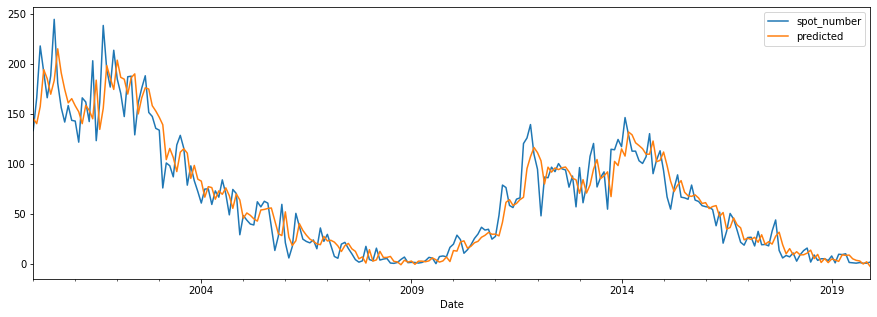

In [377]:
tt = test_data.copy()
tt['predicted'] = [a[0] for a in arima_predictions]
tt.plot(figsize=(15, 5))
plt.show()

Как видим, предсказания получились довольно неплохие.

### Задание 4.
Повторите эксперимент по прогнозированию, реализовав рекуррентную нейронную сеть (с как минимум 2 рекуррентными слоями).

Для начала необходимо подготовить данные. В первую очередь нормализуем их.

In [170]:
mean = df['spot_number'].mean()
std = df['spot_number'].std()

rnn_df = df.copy()
rnn_df["normalized"] = (rnn_df['spot_number'] - mean) / std
rnn_df

spot_number  normalized
Date                               
1749-01-31         96.7    0.215566
1749-02-28        104.3    0.327553
1749-03-31        116.7    0.510270
1749-04-30         92.8    0.158098
1749-05-31        141.7    0.878649
...                 ...         ...
2019-08-31          0.5   -1.201960
2019-09-30          1.1   -1.193119
2019-10-31          0.4   -1.203433
2019-11-30          0.5   -1.201960
2019-12-31          1.6   -1.185751

[3252 rows x 2 columns]

Затем преобразуем их к такому формату, что у нас получится задача машинного обучения с учителем. X - значения временного ряда за какой-то промежуток времени, y - значение временного ряда, следующее за окном X.

In [181]:
WINDOW = 12

X, y = [], []

for i in range(WINDOW, len(rnn_df)):
    window_history = np.array(rnn_df["normalized"][i - WINDOW:i], dtype=np.float32)
    next_value = rnn_df["normalized"][i]
    
    X.append(window_history)
    y.append(next_value)

X, y = np.array(X), np.array(y)
X = np.reshape(X, (*X.shape, 1))

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (3240, 12, 1)
y shape: (3240,)


In [183]:
X_train, X_test = X[:-len(test_data)], X[-len(test_data):]
y_train, y_test = y[:-len(test_data)], y[-len(test_data):]

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (3000, 12, 1)
y_train shape: (3000,)
X_test shape: (240, 12, 1)
y_test shape: (240,)


Построим модель с двумя реккурентными слоями GRU. В качестве метрики используем среднюю абсолютную ошибку.

In [252]:
model = keras.models.Sequential([
    keras.layers.GRU(12, input_shape=(12, 1), return_sequences=True),
    keras.layers.GRU(12),
    keras.layers.Dense(1)
])

model.compile(optimizer=keras.optimizers.Adam(lr=1e-3), loss='mae')
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_22 (GRU)                 (None, 12, 12)            540       
_________________________________________________________________
gru_23 (GRU)                 (None, 12)                936       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 13        
Total params: 1,489
Trainable params: 1,489
Non-trainable params: 0
_________________________________________________________________


In [253]:
history = model.fit(X_train, y_train, epochs=20, validation_split=0.1)

Epoch 1/20
85/85 [==============================] - 2s 20ms/step - loss: 0.3269 - val_loss: 0.3352
Epoch 2/20
85/85 [==============================] - 1s 12ms/step - loss: 0.2865 - val_loss: 0.3168
Epoch 3/20
85/85 [==============================] - 1s 13ms/step - loss: 0.2790 - val_loss: 0.3063
Epoch 4/20
85/85 [==============================] - 1s 12ms/step - loss: 0.2729 - val_loss: 0.3046
Epoch 5/20
85/85 [==============================] - 1s 14ms/step - loss: 0.2702 - val_loss: 0.3011
Epoch 6/20
85/85 [==============================] - 1s 12ms/step - loss: 0.2681 - val_loss: 0.2967
Epoch 7/20
85/85 [==============================] - 1s 13ms/step - loss: 0.2670 - val_loss: 0.3038
Epoch 8/20
85/85 [==============================] - 1s 12ms/step - loss: 0.2659 - val_loss: 0.2962
Epoch 9/20
85/85 [==============================] - 1s 12ms/step - loss: 0.2659 - val_loss: 0.2959
Epoch 10/20
85/85 [==============================] - 1s 12ms/step - loss: 0.2648 - val_loss: 0.2960
Epoch 11/

In [254]:
model.evaluate(X_test, y_test)

8/8 [==============================] - 0s 3ms/step - loss: 0.1901


0.19011487066745758

In [ ]:
preds = (mean + model.predict(X_test) * std).flatten().tolist()

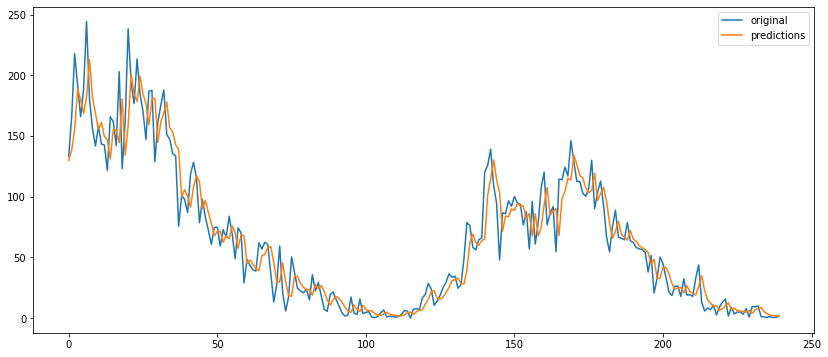

In [256]:
plt.figure(figsize=(14, 6))
plt.plot(np.arange(len(test_data)), test_data['spot_number'], label="original")
plt.plot(np.arange(len(test_data)), preds, label="predictions")
plt.legend()
plt.show()

Модель показала хорошие результаты.

### Задание 5.
Сравните качество прогноза моделей.

In [389]:
from sklearn.metrics import mean_absolute_error

arima_mae_error = mean_absolute_error(test_data.values, arima_predictions)
gru_mae_error = mean_absolute_error(test_data.values, preds)

print(f'ARIMA MAE Error: {arima_mae_error}')
print(f'RNN MAE Error: {gru_mae_error}')

ARIMA MAE Error: 12.845544682581727
RNN MAE Error: 12.902095470428467


Измерим среднюю абсолютную ошибку для обеих моделей. Они оказались приблизительно одинаковыми, однако модель ARIMA показывает слегка лучшие результаты.